# <div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">RNN pour la détection d'anomalies</div> 

<div style="font-size:16pt; line-height:25pt; font-weight:bold; ">Sommaire : </div>  

- [Pré-requis](#sec1)
- [Problématique](#sec2)
- [Des réseaux de neurones vers les RNN](#sec3)
- [Application : prise en main des RNN pour nos signaux](#sec4)
- [Différents RNN : les LSTM & les GRU](#sec5)
- [Application : utilisation des LSTM et des GRU pour la détection d'anomalies](#sec6)
- [Conclusion](#sec8)
- [Bibliographie](#sec9)



La détection d'anomalies que ce soit pour des vols, pour des réseaux de sécurité, pour le suivi d'une usine ou encore d'une centrale électrique, présente des enjeux majeurs en terme de sécurité. L'utilisation de capteurs permet de récolter de nombreuses données, puis de les soumettre à l'analyse. Néanmoins, se pose alors la question suivante : pour des données échantillonnées chaque seconde, sur plusieurs dizaines de capteurs, comment détecter un comportement "anormal" ? Comment détecter que pendant un instant, un comportement "anormal" est en train de se déclencher ? Ou bien fautil considérer qu'un comportement anormal est justement associé à un groupe de points qui, bien que normaux pris séparément, sont anormaux lorsque groupés ?

La définition de ce qui est normal ou non revient à des experts du domaine, avec qui il faudra travailler conjointement. La tâche de l'analyste sera donc de présenter des résultats lisibles, d'expliquer la démarche, et de prendre en compte les remarques des experts de la physique pour implémenter de nouvelles fonctionnalités / de nouveaux axes de recherche d'anomalies.

Pour des méthodes traditionnelles, des limites se présentent assez vite par rapport à ces algorithmes pour plusieurs raisons, une des principales étant *la malédiction de la dimension*. D'autres souffrent particulièrement du côté séquentiel des données qui est mal pris en compte, ou encore de l'aspect multivariables des données récupérées. Ainsi, une nouvelle approche ayant recours au deep learning a été mise en place en utilisant les **RNN** (Reccurent Neural Networks). En particulier, des **LSTM** (Long Short Term Memory) et des **GRU** (Gated Reccurent Units) ont été utilisées.

Les résultats obtenus selon différentes métriques (**précision**, **rappel**, **score F1**, **RMSE**) sont concluants quant à l'efficacité de ces nouvelles méthodes.


<div class="alert alert-warning">

Dans ce notebook, on repart de plus ou moins loin dans les réseaux de neurones. Il est un peu long, ne pas hésiter à aller vite sur les parties déjà maîtrisées. 
    
</div>

# <a id="sec1"></a>Pré-requis

<div class="alert alert-success">

- Notions d'algèbre linéaire (en particulier sur l'utilsiation de matrices, de vecteurs...)
- Étude et optimisation de fonctions à plusieurs variables, calcul et rôle du gradient
- La connaissance préliminaire des réseaux de neurones simples est un plus.
    
</div>

In [1]:
# Installation des modules requis en remplaçant "nom_du_module"(à decommenter au besoin)

!pip install torch

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


OSError: [WinError 126] Le module spécifié est introuvable. Error loading "C:\Users\d.botvynko\anaconda3\lib\site-packages\torch\lib\asmjit.dll" or one of its dependencies.

# <a id="sec2"></a> Problématique

<div class="alert alert-warning">

À partir d'un jeu de données (des vols simulés par exemple) , développer un RNN avec une **architecture** permettant de **classifier** correctement les anomalies.
    
</div>

# <a id="sec3"></a> Des réseaux de neurones vers les RNN

Les **réseaux de neurones** sont des architectures inspirées de la biologie liant plusieurs unités (les *neurones*) par des connexions pondérées (les *synapses*). Le mécanisme sous-jacent est que, lorsqu'un neurone amont est activé, il envoie un signal à tous ses neurones aval, chacun sera alors lui-même activé (ou non en cumulant les signaux envoyés par ses neurones amont et pondérés par les connexions qui les relient. Schématiquement cela donne :

<img src='img/ann_calc.png' width="500">

<div align="center"><em> Calcul de l'activation d'un neurone amont à partir des niveaux d'activation des neurones aval </em></div>

La structure globale d'un réseau de neurones se compose de plusieurs couches, une pour les entrées, une pour les sorties, et un nombre paramétrable pour les couches internes dites *cachées*. L'exemple suivant est composé de 4 couches, dont 2 cachées. Le réseau de neurones pris comme exemple sert pour la reconnaissance de chiffres à partir d'images de format 28 pixels par 28 pixels (d'où 784 valeurs d'entrée). 

<img src="img/ann.png" width="500">

<div align="center"><em> Schéma d'un réseau de neurones pour la reconnaissance de chiffres "manuscrits" </em></div>

<div class="alert alert-info">

Vous pouvez retrouver une approche très claire et visuelle (et que j'affectionne beaucoup), sur la chaîne *3Blue1Brown* animée par Grant Sanderson, à travers une mini-série sur les principes de base des réseaux de neurones. Les visuels ci-dessus proviennent de la première vidéo de cette mini-série.

[Liste des vidéos de *3Blue1Brown* sur les réseaux de neurones](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)    
</div>

Pour l'entraînenement de nos réseaux de neurones, les données d'entrée peuvent être étiquetées ou non, ce qui donne lieu à deux branches du **Machine Learning** : l'apprentissage supervisé et l'apprentissage non supervisé.

Le but du jeu est le suivant : disposant de données d'entrée sous le bon format, réussir à classer (donner une étiquette parmi un certain nombre possible) ou à prédire (donner un résultat numérique). On parle de classification (resp. de régression). 

Plusieurs phases sont présentes : 
- l'entraînement
- la validation
- les tests

Au cours de ces phases, les poids des connexions entre les neurones sont ajustés afin d'obtenir les meilleurs valeurs possibles d'une **fonction d'erreur** qui quantifie l'erreur des prédictions faites par nos réseaux de neurones (par exemple, s'il s'agit d'une régression en apprentissage supervisé, on peut comparer l'écart numérique entre la prédiction et la valeur attendue). 

Les réseaux de neurones sont utilisés pour de nombreuses applications diverses et variées, allant de la reconnaissance d'éléments dans des images, à l'identification d'espèces à partir d'échantillons sonores. Cependant, chacune de ces applications requiert non seulement des types de réseaux de neurones différents (convolution, réseaux récurrents, réseaux classiques), mais aussi des architectures différentes (nombre de neurones, nombre de couches, fonctionnement du passage d'une couche à la suivante...). 

Pour les données qui nous intéressent, étant donné qu'il s'agit de signaux temporels, une catégorie de réseaux de neurones présentent de bonnes performances : les **réseaux récurrents** (ou RNN). 

Les RNN se basent sur une architecture qui boucle partiellement sur elle-même : la sortie d'une cellule devient une partie de son entrée au pas de temps suivant, ce qui lui confère une sorte de mémoire. 

<div class="alert alert-success">

**Notations :**

$x_t$ : vecteur d'entrée \
$h_t$ : vecteur de l'état caché \
$o_t$ : vecteur de sortie \
$b_o , b_h$ : vecteurs de biais \
$U_h, U_o , W_h$ : matrices de poids

$ \odot $ correspond au produit terme à terme.

</div>

Les équations de la propagation en avant sont : 

$$
h_t = tanh( W_h * x_t + U_h * h_{t-1} + b_h)\\
o_t = \sigma (U_o * h_t + b_o)
$$

<img src='img/rnn.png' width="500">

<div align="center"><em> Schéma d'une cellule d'un RNN </em></div>

Nous allons brièvement voir l'implémentation sous `torch` des cellules de RNN. Toute la documentation associée peut être trouvée [ici](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). A l'aide de la méthode `RNNCell` nous allons simuler une unique cellule.

Note : nous ne manipulons pas des `arrays` classiques, mais des **tenseurs** `torch`.
Plus d'informations théoriques sur les tenseurs [ici](https://fr.wikipedia.org/wiki/Tenseur).
Pour la prise en main des tenseurs sous `torch` [c'est par ici](http://www.python-simple.com/python-torch/torch-intro.php)

In [2]:
# La cellule attend une entrée x_t de taille 5, et présente une couche cachée h_t de taille 16.
rnn = nn.RNNCell(5, 16)

In [3]:
# On définit une entrée x_t aléatoire de taille 5, et on initialise la couche cachée à 0.
# Le premier "1" correspond au nombre de pas de temps.
x_t = torch.randn(1, 5)
h_t = torch.zeros(1, 16)
x_t, h_t

(tensor([[ 0.4326, -0.6906,  0.3474, -0.0734,  0.7275]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [4]:
# Ainsi, suite à une propragation en avant, on obtient une sortie comme suit :
out = rnn(x_t, h_t)
out

tensor([[-0.1085, -0.1500, -0.1557, -0.4152, -0.0523, -0.1989, -0.3425,  0.1295,
          0.4907, -0.1123,  0.2859,  0.0106,  0.0472,  0.3050, -0.5711, -0.4908]],
       grad_fn=<TanhBackward>)

À noter, la sortie que nous obtenons est de la même taille que celle de la couche cachée. Si nous souhaitons obtenir une sortie de même taille que l'entrée, il faut réutiliser une couche supplémentaire (classique).

<div class="alert alert-success">

**Exercice :**     
    
Si on souhaite désormais avoir plus de paramètres d'entrées, quel nombre modifier ? Et pour changer la taille de la couche cachée, où cela se passe-t-il ?

A quoi correspond le "1" présent dans l'initialisation des tenseurs `torch` ?
    
</div>

# <a id="sec4"></a> Application : prise en main des RNN pour nos signaux

Dans le papier proposant l'utilisation de RNN pour la détection d'anomalies pour des données de vol, toute une procédure est appliquée pour créer des données à partir d'une simulation sur X-plane [1]. Nous utiliserons à la place un jeu de données non étiqueté sur les performances en vol d'un avion à partir de 11 capteurs. 

Les données des 11 capteurs sont découpées selon une nomenclature "Jour / Cycle / Fenêtre" où une fenêtre peut comprendre jusqu'à 100 mesures. Les séries temporelles que nous considérerons seront alors l'ensemble des mesures sur une fenêtre. Seules les fenêtres de fin de cycle présentent moins de 100 mesures, mais ceci ne poserait pas particulièrement de souci pour l'implémentation que nous étudierons en fin de notebook. Toutefois, pour une première étude, nous ne conserverons que celles à 100 mesures exactement.

La démarche sera la suivante : nous allons calibrer un RNN pour que celui soit capable de prédire correctement nos signaux. Quand ce calibrage sera suffisamment robuste, même pour des signaux encore inconnus du RNN, nous pourrons alors qualifier comme anormaux des signaux qui s'écarteront trop de la prédiction. C'est le point de vue un peu qualitatif, la quantification sera apportée au fur et à mesure des étapes !

In [11]:
ac_df = pd.read_csv('data/ac_dataset.csv')

In [12]:
# Vérification de routine pour d'éventuelles valeurs NaN :
print(ac_df.isnull().values.any())

# Tous les noms de paramètres commencent par "p". Il y en a 11
feat_list = []
for col in ac_df.columns :
    
    if col.startswith("p") :
        feat_list.append(col)
n_feat = len(feat_list)        
print(feat_list)

# Décomposition de l'ensemble des données par jour_cycle_fenêtre

key_list = ac_df["day_cycle_window"].unique()


False
['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11']


In [13]:
signals = []

for key in key_list :
    if len(ac_df[ ac_df["day_cycle_window"] == key].index) == 100 :
        signals.append(ac_df.loc[ ac_df["day_cycle_window"] == key, feat_list]) 

sig_data = np.array(signals)
nsig  = len(sig_data)


Empiriquement, il serait meilleur pour nos RNN de normaliser les signaux de chaque capteur entre -1 et 1 grâce à la connaissance des extrema au sens physique. Puisque nous ne les connaissons pas, nous préférerons garder les données brutes. Visualisons tout de même l'allure d'un signal pris au hasard :

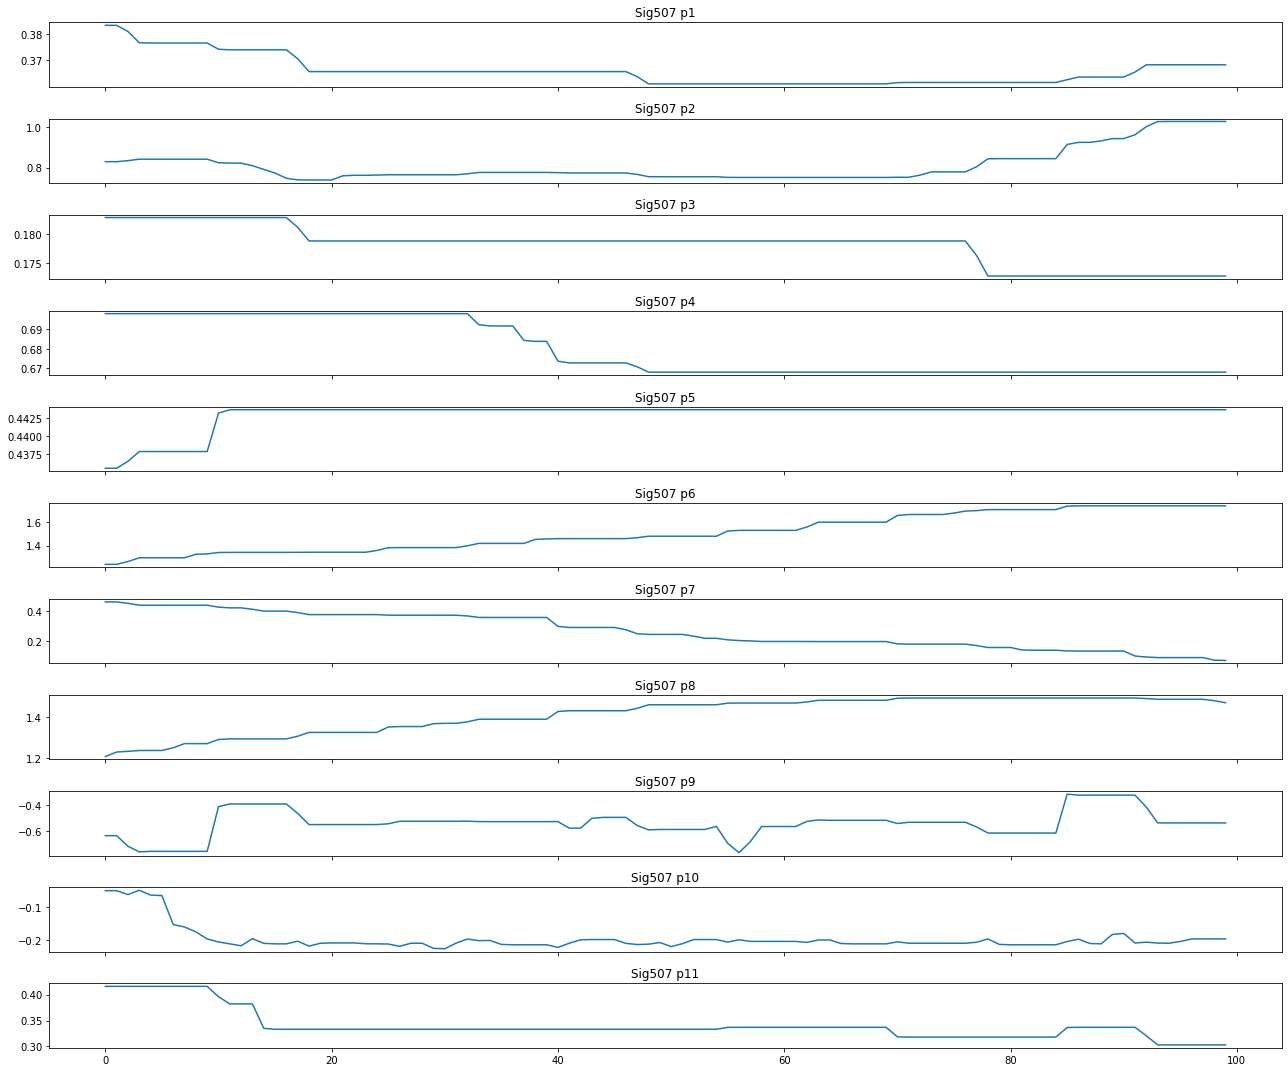

In [108]:
rd_idx = np.random.randint(nsig)
sig_vis = np.array(sig_data[rd_idx])

fig, axs = plt.subplots(n_feat, sharex=True, figsize=(18,15))

for j in range (n_feat) :
    axs[j].plot(sig_vis[:,j])
    axs[j].set_title('Sig'+str(rd_idx)+" p"+str(j+1))
fig.tight_layout()

Sans plus attendre, il est l'heure de définir notre premier RNN adapté pour les données présentées ci-dessus ! Nous allons démarrer avec la version la plus basique possible, puis nous allons monter en complexité petit à petit en incluant plus de "fonctionnalités". La documentation sous `torch` pour la classe `RNN` est disponible [ici](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).

In [189]:
class SimpleRNN(nn.Module):
    
    def __init__(self, in_size, h_size, out_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = h_size
        self.rnn1 = nn.RNNCell(in_size, h_size)
        # On utilise une couche classique pour transformer la couche cachée h_(t+1) en sortie y_(t+1)
        self.linear = nn.Linear(h_size, out_size)

    def forward(self, input):
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        out = []
        for x_t in input.split(1, dim=1):
            h_t = self.rnn1(x_t.squeeze(), h_t)
            y_t = self.linear(h_t).unsqueeze(1)
            out += [y_t]
        out = torch.cat(out, dim=1)
        return out, h_t

Ici, nous disposons d'un signal temporel qui est multi-varié. Or, pour `torch`, le signal d'entrée qui est attendu doit être un tenseur de dimensions : 

taille du "batch" * nombre de pas de temps * nombre de paramètres

Nous mettons donc notre tenseur au format correct.

In [105]:
n_hid = 16
rnn = SimpleRNN(n_feat, n_hid, n_feat).double()
x_inp = torch.from_numpy(sig_data[0:5])


In [106]:
# Le context manager torch.no.grad() permet une propagation en avant plus rapide
# (puisqu'on souhaite juste obtenir la sortie de notre réseau)

with torch.no_grad():
    output, _ = rnn(x_inp)
    y_out = output.detach().numpy()

Avec ce simple passage, observons un peu les prédictions de notre RNN non entraîné. En bleu nous affichons le signal d'origine, en rouge la prédiction faite par notre RNN (qui correspond au signal décalé d'un pas de temps 1).

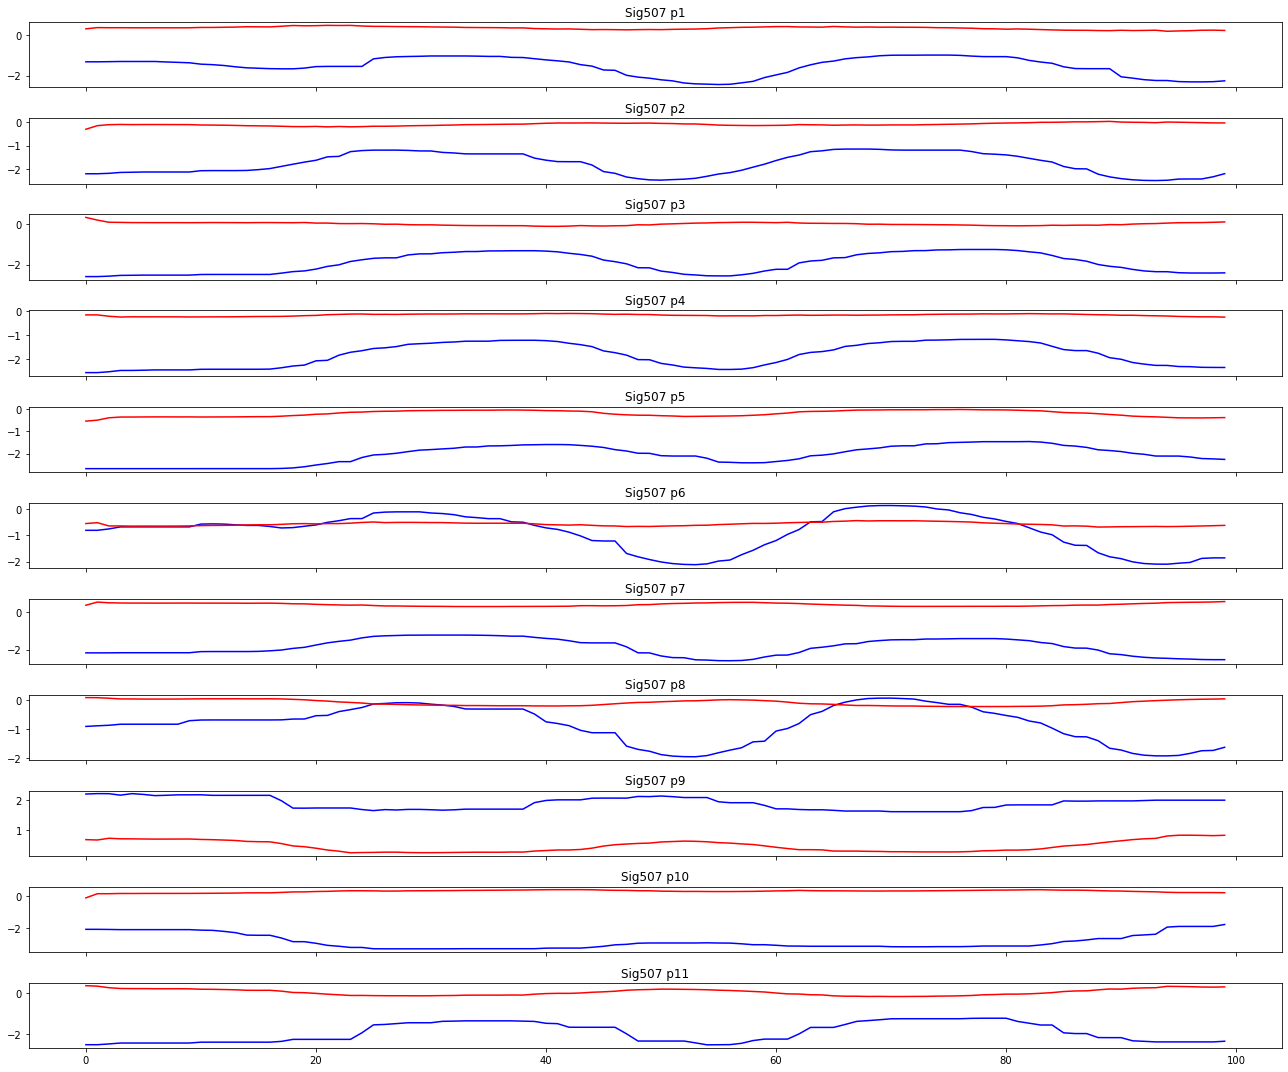

In [109]:
sig = x_inp[2]
pred = y_out[2]

fig, axs = plt.subplots(n_feat, sharex=True, figsize=(18,15))

for j in range (n_feat) :
    axs[j].plot(sig[:,j],color='b')
    axs[j].plot(pred[:,j],color='r')
    axs[j].set_title('Sig 3 p'+str(j+1))
fig.tight_layout()

Les étapes classiques qui suivent consistent à optimiser nos poids que nous avions définis plus tôt à l'échelle des cellules unitaires (les matrices $W, U$), afin que par une **fonction de coût** l'écart entre le signal et la prédiction soit minimisée. 

Nous utiliserons l'optimiseur LBFGS et la fonction de coût de l'erreur quadratique moyenne (ou MSE en anglais).

In [121]:
rnn = SimpleRNN(n_feat, n_hid, n_feat).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.8)

In [122]:
# Une étape d'entraînement avec nos données
def closure():
    optimizer.zero_grad()
    out, hidden = rnn(x_inp)
    loss = criterion(out[:, :-1,:], x_inp[:, 1:,:])
    print('Ecart moyen entre les prédictions et le signal:', loss.item())
    loss.backward()
    return loss

In [123]:
optimizer.step(closure)

Ecart moyen entre les prédictions et le signal: 4.163099138871896
Ecart moyen entre les prédictions et le signal: 3.973692703928741
Ecart moyen entre les prédictions et le signal: 0.47831158475161695
Ecart moyen entre les prédictions et le signal: 0.3530121418904379
Ecart moyen entre les prédictions et le signal: 0.32858930834361993
Ecart moyen entre les prédictions et le signal: 0.3173225951271688
Ecart moyen entre les prédictions et le signal: 0.6322215913261767
Ecart moyen entre les prédictions et le signal: 0.2833703992854655
Ecart moyen entre les prédictions et le signal: 0.28424050049683086
Ecart moyen entre les prédictions et le signal: 0.26323647282452284
Ecart moyen entre les prédictions et le signal: 0.2949469290907955
Ecart moyen entre les prédictions et le signal: 0.24901517266975343
Ecart moyen entre les prédictions et le signal: 0.29364485197347456
Ecart moyen entre les prédictions et le signal: 0.2471833313819286
Ecart moyen entre les prédictions et le signal: 0.22195227

tensor(4.1631, dtype=torch.float64, grad_fn=<MseLossBackward>)

Suite à cet entraînement se basant sur une fraction de tous nos signaux, nous pouvons regarder les nouvelles prédictions de notre réseau : 

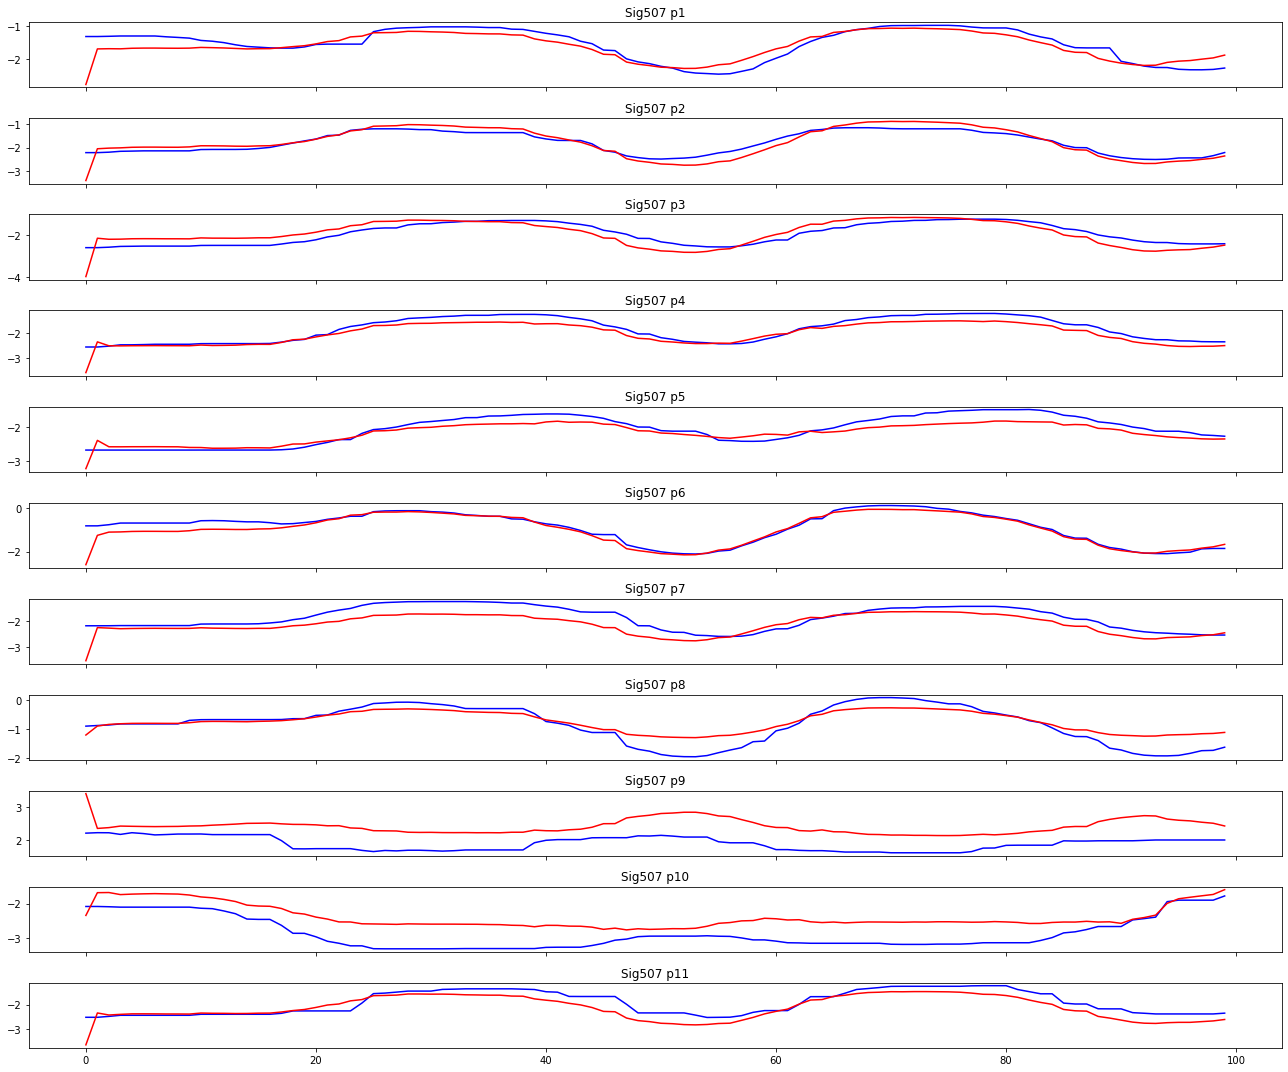

In [124]:
with torch.no_grad():
    output, _ = rnn(x_inp)
    y_out = output.detach().numpy()

sig = x_inp[2]
pred = y_out[2]

fig, axs = plt.subplots(n_feat, sharex=True, figsize=(18,15))

for j in range (n_feat) :
    axs[j].plot(sig[:,j],color='b')
    axs[j].plot(pred[:,j],color='r')
    axs[j].set_title('Sig 3 p'+str(j+1))
fig.tight_layout()

Les résultats ne semblent pas si mauvais graphiquement ! Toutefois, nous comparons ici une prédiction faite pour un signal qui nous a servi à l'entraînement. Qu'en est-il pour un signal totalement inconnu pour notre RNN ?

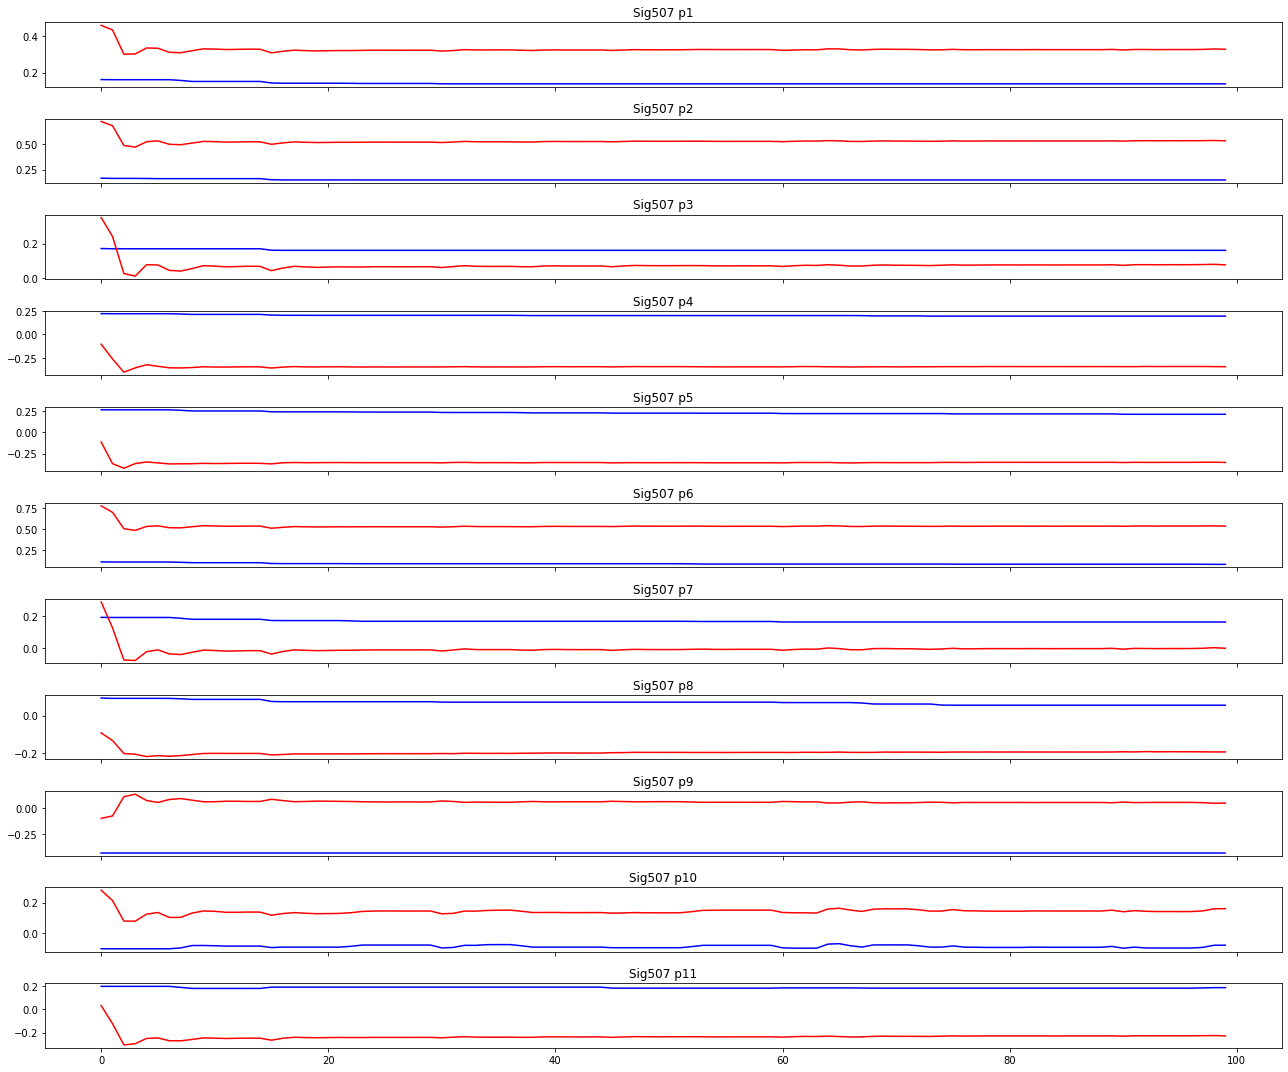

In [125]:
new_x_inp = torch.from_numpy(sig_data[10:15])

with torch.no_grad():
    output, _ = rnn(new_x_inp)
    new_y_out = output.detach().numpy()

sig = new_x_inp[2]
pred = new_y_out[2]

fig, axs = plt.subplots(n_feat, sharex=True, figsize=(18,15))

for j in range (n_feat) :
    axs[j].plot(sig[:,j],color='b')
    axs[j].plot(pred[:,j],color='r')
    axs[j].set_title('Sig 12 p'+str(j+1))
fig.tight_layout()

C'est tout de suite moins convaincant... Pour cela, il nous utiliser le principe de séparation des jeux de données. 

Le principe est le suivant : une certain proportion de nos données vont servir à entraîner notre modèle, une seconde partie servira à évaluer sa capacité à généraliser. Les proportions souvent utilisées sont de l'ordre de 80% / 20%.

In [130]:
def split_train_test(ntot, prop=0.8) :
    
    idx = np.arange(ntot)
    np.random.shuffle(idx)
    
    return idx[:int(prop*ntot)], idx[int(prop*ntot):]

In [133]:
idx_train , idx_test = split_train_test(nsig)

X_train = np.array(sig_data[idx_train])
X_test  = np.array(sig_data[idx_test])

In [135]:
rnn_2 = SimpleRNN(n_feat, n_hid, n_feat).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn_2.parameters(), lr=0.8)

x_inp = torch.from_numpy(X_train)


In [139]:
optimizer.step(closure)

Ecart moyen entre les prédictions et le signal: 0.5209583210421485


tensor(0.5210, dtype=torch.float64, grad_fn=<MseLossBackward>)

Text(0.5, 1.05, 'SIGNAL DE TEST')

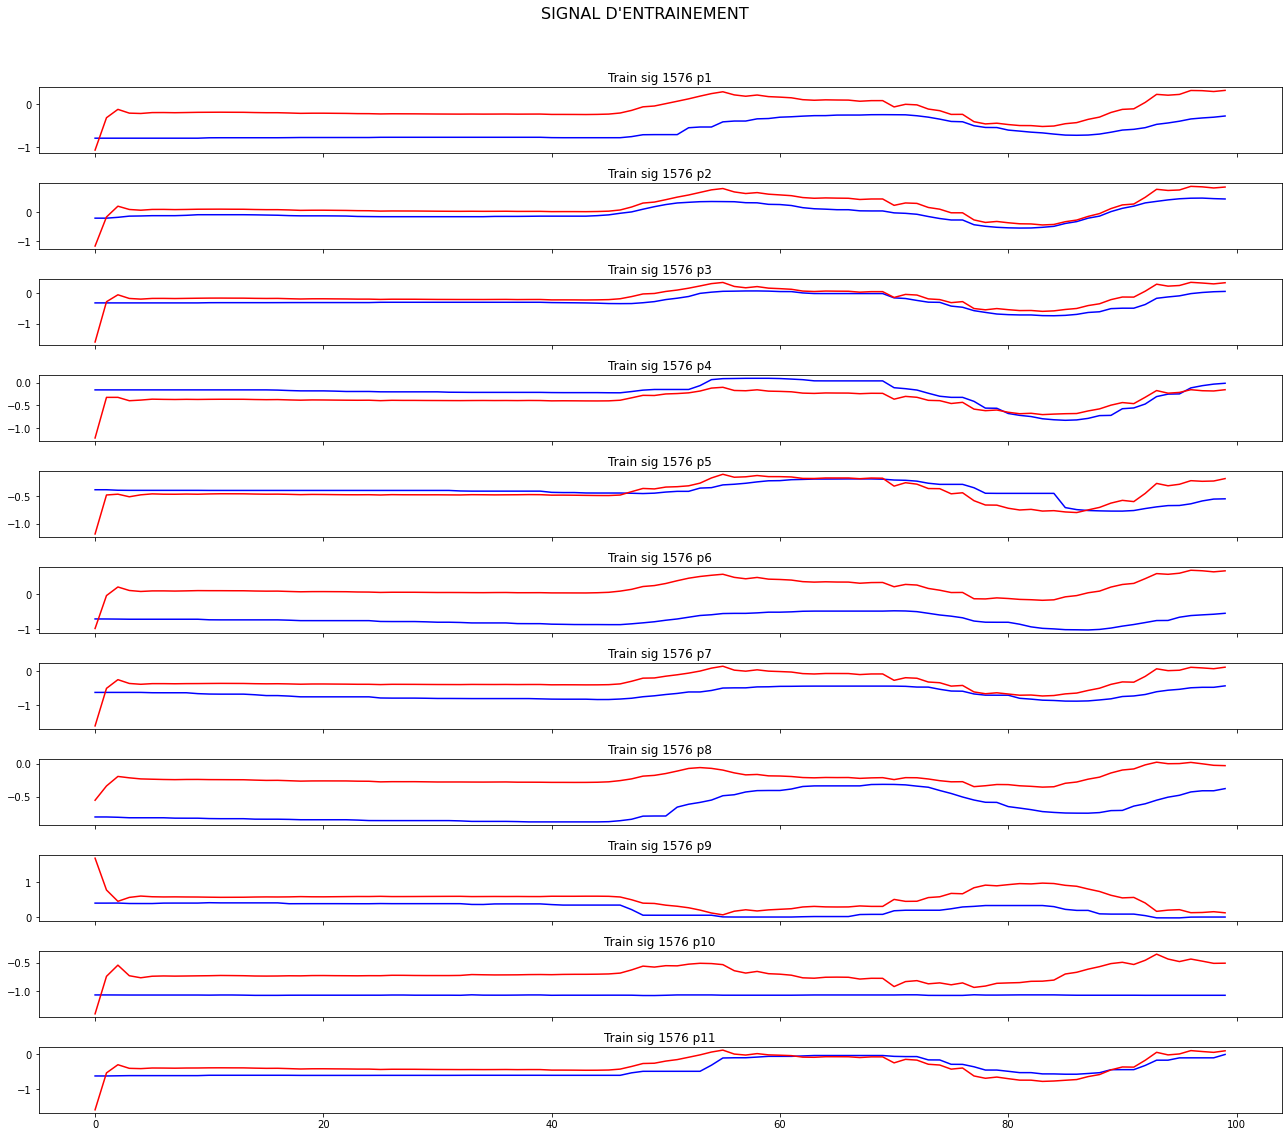

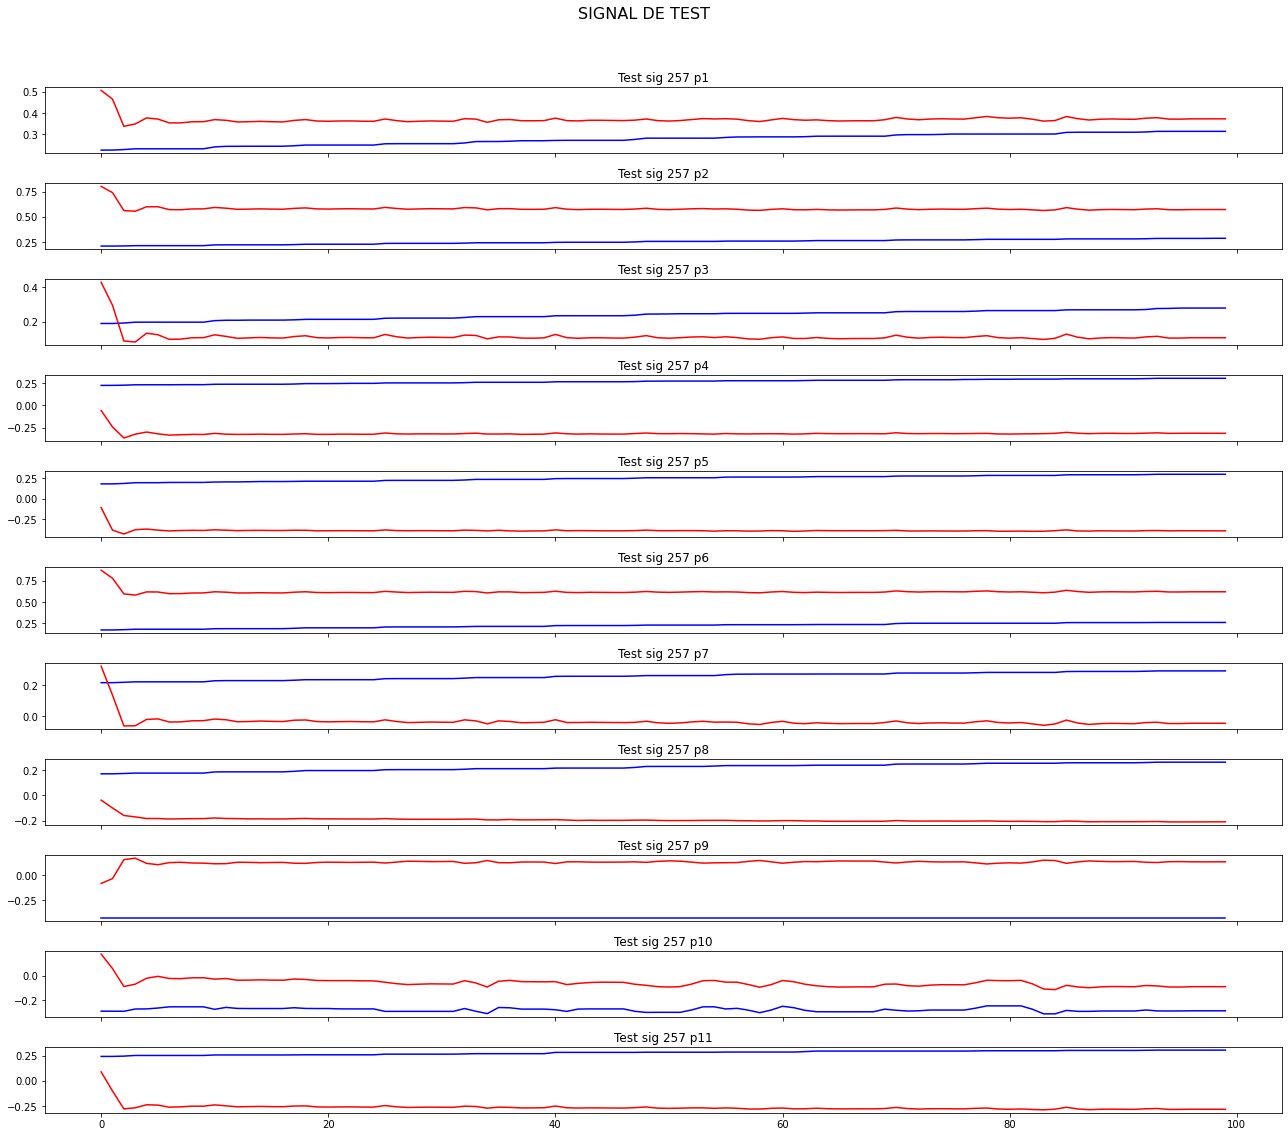

In [166]:
rnd_train_idx = np.random.choice(idx_train,2)
rnd_test_idx  = np.random.choice(idx_test,2)

x_train_inp = torch.from_numpy(sig_data[rnd_train_idx])
x_test_inp  = torch.from_numpy(sig_data[rnd_test_idx])


with torch.no_grad():
    output, _ = rnn(x_train_inp)
    train_y_out = output.detach().numpy()
    
with torch.no_grad():
    output, _ = rnn(x_test_inp)
    test_y_out = output.detach().numpy()
    
train_sig  = x_train_inp[0]
train_pred = train_y_out[0]

test_sig  = x_test_inp[0]
test_pred = test_y_out[0]

fig, axs = plt.subplots(n_feat, sharex=True, figsize=(18,15))
for j in range (n_feat) :
    axs[j].plot(train_sig[:,j],color='b')
    axs[j].plot(train_pred[:,j],color='r')
    axs[j].set_title('Train sig '+str(rnd_train_idx[0])+' p'+str(j+1))
fig.tight_layout()
fig.suptitle("SIGNAL D'ENTRAINEMENT", fontsize=16, y=1.05)

fig2, axs2 = plt.subplots(n_feat, sharex=True, figsize=(18,15))

for j in range (n_feat) :
    axs2[j].plot(test_sig[:,j],color='b')
    axs2[j].plot(test_pred[:,j],color='r')
    axs2[j].set_title('Test sig '+str(rnd_test_idx[0])+' p'+str(j+1))
fig2.tight_layout()
fig2.suptitle("SIGNAL DE TEST", fontsize=16, y=1.05)


En fonction des signaux que l'on observe, les résultats sont plus ou moins probants pour la phase de tests. A partir de là, il est temps de commencer à implémenter des structures un peu plus complexes.

<div class="alert alert-success">

**Exercice :**     
    
En se basant sur le code précédent, construire un `RNN` présentant une architecture avec 3 cellules consécutives (et se terminant encore une fois par une couche linéaire). L'entraîner puis le tester avec le jeu de données présenté au-dessus.
    
</div>

Le paramètre d'instanciation `num_layers` peut directement gérer ceci si on utilise la classe `nn.RNN`. Mais à la main, en utilisant la classe `nn.Module`, voici comment nous pouvons procéder.

Pour avoir la solution, décommenter la cellule ci-dessous et l'exécuter.

In [ ]:
#%load solutions/tri_rnn.py

Plusieurs hyper-paramètres sont présents pour l'entraînement des réseaux de neurones : le **taux d'apprentissage** (ou *learning rate* en anglais, noté `lr`), est un paramètre de l'optimiseur pour effectuer les calculs d'ajustement des poids de notre réseau.

D'autres hyper-paramètres existent comme : 
- la **taille du lot** (ou *batch size* en anglais) : c'est le nombre de signaux d'entrée que l'on présente à la fois au réseau avant de mettre à jour ses paramètres
- le **nombre d'époques** (ou *epoch* en anglais) : c'est le nombre de fois où l'on itère l'optimisation sur l'ensemble de notre jeu de données.

Plus d'explications par [ici](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/).

Tous ces hyper-paramètres ont une influence sur les performances de nos réseaux. Dans leur article sur la détection d'anomalies en utilisant des RNN, Nanduri et Sherry ont justement évalué les performances de réseaux en faisant varier, entre autres, la taille du lot et le nombre d'époques [1].

<div class="alert alert-success">

**Exercice :**     
    
On se propose maintenant de gérer plusieurs *époques* d'entraînement. Changer la taille du lot pour observer les effets sur les métriques de notre modèle. 
    
*Complément :* 
    
Dans l'ordre il faudrait, initialiser le RNN et l'optimiseur, séparer les jeux de données en entraînement et en test, avant de débuter l'entraînement (boucle sur les époques, et dans chaque époque sur l'ensemble des lots).
    
</div>

In [ ]:
#%load solutions/train_tri_rnn.py                     

Bref point sur une notion utilisée pour limiter le **sur-aprentissage** (le fait de trop coller aux données d'entraînement et de perdre en capacité de généralisation) : le *décrochage* (ou dropout en anglais). 

Au lieu de connecter pleinement nos couches successives, une proportion des neurones sont désactivés lors des phases d'entraînement. Ceci permet de gagner en robustesse.

<div class="alert alert-success">

**Exercice :**     
    
Un petit dernier apport pour la route : implémenter du *décrochage* pour un nouveau réseau.
</div>

In [197]:
#% load solutions/dropout_rnn.py

# <a id="sec5"></a> Différents RNN : les LSTM & les GRU

Maintenant que nous avons vu les bases théoriques et d'implémentation pour les RNN basiques, passons à deux variantes : les **LSTM** et les **GRU**.

Les **LSTM** (Long Short Term Memory) et les **GRU** (Gated Reccurent Unit) sont des RNN présentant des architectures cellules spéciales. Elles comportent des connexions supplémentaires qui ajoutent une composante de mémoire qui est en permanence mise à jour. Nous appellerons ces connexions des "portes". Chacune joue un rôle différent. 

La différence entre ces deux sous-catégories vient du fait que les **LSTM** présentent plus de types différents de portes, là où pour les **GRU** elles ont été "agrégées". 

Pour les **LSTM**, il y a trois portes différentes :
- la porte d'oubli
- la porte d'entrée
- la porte de sortie

La mémoire à court-terme est représentée par le vecteur d'état caché *h_t*, tandis que la mémoire à long-terme est contenue dans le vecteur *C_t*. Les différentes portes se servent de l'information à court-terme et des nouvelles entrées *x_t* pour mettre à jour la mémoire long-terme, qui elle-même produira en sortie une mémoire à court-terme mise à jour. 

<div class="alert alert-success">

**Notations :**

$x_t$ : vecteur d'entrée \
$h_t$: vecteur de l'état caché \
$C_t$ : vecteur d'état caché - mémoire long-terme\
$f_t$ : vecteur de la "porte" d'oubli\
$i_t$ : vecteur de la "porte" d'entrée\
$o_t$ : vecteur de la "porte" de sortie\
$b_f , b_i, b_o, b_c$ : vecteurs de biais \
$W_f, W_i, W_o, W_c, U_f, U_i, U_o, U_c$ : matrices de poids

    
$ \odot $ correspond au produit terme à terme.
    
</div>


Les équations de la propagation en avant sont : 

$$
f_t = \sigma ( W_{f} * x_t + U_{f} * h_{t-1} + b_f )\\
i_t = \sigma ( W_{i} * x_t + U_{i} * h_{t-1} + b_i )\\
o_t = \sigma ( W_{o} * x_t + U_{o} * h_{t-1} + b_o )\\
\widetilde{C_t} = tanh( W_{c} * x_t + U_{c} * h_{t-1} + b_c)\\
C_t = f_t \odot C_{t-1} + i_t \odot \widetilde{C_t}\\
h_t = o_t \odot tanh(C_t)
$$

<img src='img/lstm.png' width="500">

<div align="center"><em> Schéma d'une cellule d'un LSTM (note : un des deux h_t de sortie est en fait la sortie)</em></div>

On peut, comme pour les RNN, utiliser la classe `LSTMCell` pour observer le fonctionnement d'une seule cellule. La documentation est [ici](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html).

In [5]:
# La cellule attend ici aussi une entrée x_t de taille 5, et présente une couche cachée h_t de taille 16.
basic_lstm = nn.LSTMCell(5,16)

In [6]:
# Les formats pour x_t et h_t sont les mêmes que pour leurs homologues des RNN. c_t a le même format que h_t
x_t = torch.randn(1, 5)
h_t = torch.zeros(1, 16)
c_t = torch.zeros(1, 16)

In [7]:
# Les sorties se composent d'un tenseur pour le nouvel état caché h_t, mais aussi du nouvel état de mémoire
# c_t :
out, c_t1 = basic_lstm(x_t, (h_t, c_t))
out , c_t1

(tensor([[ 0.0342, -0.0155,  0.1219, -0.0158, -0.0786,  0.0758,  0.0839,  0.0609,
           0.1032,  0.0962, -0.0048, -0.0107,  0.0078,  0.0196, -0.0629,  0.0150]],
        grad_fn=<MulBackward0>),
 tensor([[ 0.0652, -0.0375,  0.1817, -0.0282, -0.1426,  0.1773,  0.2001,  0.1217,
           0.1869,  0.2248, -0.0082, -0.0210,  0.0188,  0.0413, -0.1627,  0.0269]],
        grad_fn=<AddBackward0>))

Pour les **GRU**, il y a trois portes différentes :
- la porte de mise à jour
- la porte de remise à zéro

<div class="alert alert-success">

**Notations :**

$x_t$ : vecteur d'entrée \
$h_t$ : vecteur de l'état caché \
$r_t$ : vecteur de la "porte" de mise à jour\
$z_t$ : vecteur de la "porte" de remise à zéro\
$b_z , b_r, b_h$ : vecteurs de biais \
$W_z, W_r, W_h, U_z, U_r, U_h$ : matrices de poids

$ \odot $ correspond au produit terme à terme.

</div>

Les équations de la propagation en avant sont : 

$$
z_t = \sigma ( W_{z} * x_t + U_{z} * h_{t-1} + b_z )\\
r_t = \sigma ( W_{r} * x_t + U_{r} * h_{t-1} + b_r )\\
\widetilde{h_t} = tanh( W_{h} * x_t + U_{h} * (h_{t-1} \odot r_t) + b_h)\\
    h_t = (1 - z_t ) \odot h_{t-1} + z_t \odot \widetilde{h_t}
$$

<img src='img/gru.png' width="500">

<div align="center"><em> Schéma d'une cellule d'un GRU </em></div>

Comme précédemment, la documentation pour l'implémentation de la classe `GRUCell` sous `torch` est disponible [ici](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html).

In [8]:
# La cellule attend ici aussi une entrée x_t de taille 8, et présente une couche cachée h_t de taille 16.
basic_gru = nn.GRUCell(8,16)

In [49]:
# Par rapport au LSTM, pas besoin de c_t en entrée.
x_t = torch.randn(1, 8)
h_t = torch.zeros(1, 16)

In [48]:
# Les sorties ne se composent plus que d'un tenseur pour le nouvel état caché h_t (comme la cellule RNN)
out = basic_gru(x_t, h_t)
out

tensor([[ 0.1088,  0.2662, -0.0392,  0.1258,  0.1359, -0.2873, -0.2955, -0.0155,
         -0.0580, -0.1066, -0.2147,  0.1945, -0.1938,  0.2934,  0.2275,  0.1699],
        [ 0.1889, -0.1317,  0.1112, -0.0457, -0.1830, -0.0673,  0.1352, -0.3344,
          0.0139, -0.0680,  0.2453, -0.4869, -0.0836, -0.0233, -0.0294, -0.2355],
        [ 0.1469,  0.2313, -0.0957,  0.2001, -0.1865,  0.1600, -0.3847,  0.1669,
         -0.0233,  0.0269, -0.2912, -0.0432, -0.1936,  0.1604,  0.0311,  0.4923],
        [-0.0466,  0.1900, -0.1017,  0.1221,  0.2073, -0.1636, -0.2432,  0.2190,
         -0.0498, -0.1776, -0.0585,  0.1622, -0.2534,  0.3145,  0.1492,  0.1891],
        [ 0.0110,  0.1287,  0.2086, -0.2546, -0.1252,  0.0140,  0.1652, -0.3235,
          0.1925,  0.0626, -0.0341, -0.1268, -0.1107,  0.2453, -0.0425, -0.1616]],
       grad_fn=<AddBackward0>)

<div class="alert alert-warning">

**Recommandation :**     
    
Bien comprendre les paramètres de dimensionnement des tenseurs pour ces deux variantes avant de passer à la suite !   
</div>

# <a id="sec6"></a> Application : utilisation des LSTM et des GRU pour la détection d'anomalies

Après cette explication sur la prise en main pratique des RNN, ainsi que la découverte d'aspects plus fondamentaux sur leur fonctionnement, il est désormais temps de mettre à profit nos connaissances nouvellement acquises pour la détection d'anomalies !

A travers les différents papiers sur lesquels nous allons avoir un aperçu du travail réalisé, différents problèmes sont posés, différentes architectures et techniques utilisées.

La première question qui vient lors de la détection d'anomalies serait logiquement : qu'est-ce qu'une anomalie ? A cela on peut répondre deux choses : 

- ou bien le jeu de données est étiqueté et l'on souhaite pouvoir classifier de nouvelles données comme étant normales ou non (plutôt de l'apprentissage supervisé)
- ou bien le jeu de données est brute, nous ne savons pas quelles données sont normales ou non

Dans ce second cas, nos différents RNN peuvent être utilisés pour prévoir le signal pas à pas, comparer la prédiction avec le véritable signal, et conclure selon certains critères. De manière plus rigoureuse, il faut mettre au point une fonction de décision ou un classifieur qui viendra en aval de notre réseau. 

Voyons voir un peu plus en détails ce qui est proposé dans ces différents papiers.

<div class="alert alert-success">
    
**Exercice** :
    
Implémenter cette première version naïve de la détection d'anomalies en comparant le signal et sa prédiction. On pourra utiliser un LSTM ou un GRU. 
    
*Complément :* 
    
On pourra utiliser l'erreur relative moyenne comme proposé dans [2].
</div>

In [198]:
#%load solutions/naive_detection.py

Dans leur papier, Nanduri et al. utilisent 11 scénarios pré-définis pour classer des vols entiers comme anormaux ou non,  à partir de mesures réalisées sur 21 capteurs [1] (les données ont été simulées avec un programme du nom de X-plane et ne proviennent pas de véritables vols). Différentes architectures de GRU et de LSTM sont éprouvées en modifiant différents hyper-paramètres comme la taille du lot, le nombre de couches cachées, le nombre d'époches, le décrochage. 9 des 11 scnarios sont correctement identifiés comme anormaux, ce qui présente une avancée par rapport aux scénarios précédents.

Par rapport aux méthodes précédemment utilisées, les RNN se démarquent par une meilleure prise en compte :

- des anomalies de temps court (quelques pas de temps)
- des paramètres dits "latents" ou dérivés, qui correspondent à des combinaisons des paramètres étudiés

Les métriques utilisées pour comparer les performances sont les suivantes : 

- **la précision** : la proportion de vols détectés anormaux à raison par rapport au total du nombre de vols détectés anormaux, ou en d'autres termes, le nombre de vrais positifs détectés divisé par la somme des positifs détectés
- **le rappel** : la proportion de vols détectés anormaux à raison par rapport au total de nombre de vols effectivement anormaux, ou en d'autres termes, le nombre de vrais positifs détectés divisé par le nimbre de vrais positifs  
- **le score F1** : moyenne harmonique des deux indicateurs précédents


<img src='img/precision_rappel.png' width="350">

<div align="center"><em> Illustration graphique des principes de précision et de rappel </em></div>

Une autre métrique utilisée est la **RMSE** (pour Root Mean Squared Error en anglais, soit la racine carré de l'erreur quadratique moyenne). Pour le seul hyper-paramètre du nombre d'époques variant et pour les anomalies correctement identifiées, ce sont les LSTM qui présentent une meilleure performance selon cette métrique (devenant meilleurs le nombre d'époques augmentant).

Pour calibrer les LSTM qu'ils ont utilisés, Bontemps et al. disposaient de données assurées "normales" [2]. L'idée dans ce deuxième papier, est de s'occuper d'anomalies dans un sens un peu plus large. Selon, la perception usuelle d'une "anomalie" serait un point unique et isolé de par une valeur trop différente des autres. Or selon les auteurs, ceci est un peu trop restrictif. Une valeur isolée peut très bien correspondre à un comportement normal, tandis qu'un groupe de valeurs plus usuelles peut être un groupe d'anomalies. Quand on parle d'attaques sur des réseaux (comme des *DoS* ou refus de service), on se trouve plutôt dans ce second cas d'anomalies groupées.

Ainsi, Bontemps et al. définissent deux indicateurs pour détecter leurs anomalies : le coefficient de danger et l'erreur relative moyenne. Ces deux mesures se basent elles-même sur l'écart relatif absolu entre le signal à un instant et la prédiction faite par leur LSTM. Deux seuils sont définis pour venir agréger les résultats : le seuil d'erreur relative (pour dire si un point est anormal ou non), et le temps minimal d'attaque. Seront détectés comme anormaux les signaux pour lesquels le coefficient de danger et l'erreur relative moyenne dépassent deux seuils ($\alpha$ et $\beta$) qui sont calibrés pour leur part sur les données de validation.

Les résultats présentés ont été faits avec la plupart des seuils fixés et $\beta$ variable. On y voit encore une fois des métriques autour du nombre de faux positifs et de vrais positifs. 

<div class="alert alert-warning">

Mais pour l'instant, ce sont des cas où l'on savait ce qu'étaient les anomalies, ou bien l'on disposait de données normales... Pour l'exemple que nous avons choisi, le problème est différent, que pouvons-nous faire ?
</div>

Parmi la littérature, jetons un coup d'oeil à deux papiers qui parlent justement de la détection d'anomalies pour des séries temporelles avec une approche non supervisée (et utilisant des RNN toujours).

Pour Zhang et al., utiliser des RNN permet de capturer à la fois l'inter-corrélation et la dépendance temporelle de séries temporelles à multiples variables. Ils proposent un Multi-Scale Convolutional Reccurent Encoder-Decoder (MSCRED) [4], qui met à profit différentes architectures connues de réseaux de neurones : création de matrices multi-couches servant d'entrée à une partie convolutionnelle, qui nourrit ensuite un LSTM convolutionnel utilisant des principes *d'attention*, pour finir par recréer le signal d'entrée et étudier le signal résiduel. C'est ce second signal qui permettra de statuer sur le caractère anormal ou non d'un signal.

Dans leur papier, Ergen et al. s'attèlent à cette tâche. Leur idée est d'utiliser des LSTM pour obtenir des signaux de longueur, et de coupler ceci avec des **one-class support vector machines**, une autre méthode déjà éprouvée pour la détection d'anomalies [3]. Ceux-ci étaient déjà utilisés pour détecter des séries temporelles anormales, toutefois, de bonnes performances n'étaient atteintes que pour des temps longs.

Les auteurs soulignent la difficulté de ne se baser que sur l'écart entre signal et prédiction faite par un RNN pour classer ce qui est anormal ou non : si une anomalie correspond à ce que l'on ne peut prévoir à partir de données, il faut adjoindre à ceci un certain modèle probabiliste pour classifier, modèle utilisant lui-même des seuils à optimiser...

La démarche complète utilisée par ces auteurs est présentée ci-dessous. Nous allons l'implémenter, sans forcément réutiliser les mêmes architectures de LSTM pour autant. A noter par ailleurs, les auteurs précisent que leur algorithme est générique : les LSTM peuvent sans souci être remplacés par des GRU !

<img src='img/unsup_anomaly.png' width="500">

<div align="center"><em> Schéma de principe de la méthode proposée par Ergen et al. </em></div>

Rentrons dans les détails :

Le procédé pour obtenir des sorties de taille fixe après notre LSTM est une *aggrégation* (ou pooling en anglais). Dans le papier originel, les auteurs utilisent la valeur moyenne. Ici, nous allons limiter l'utilisation de cette couche en ne conservant que les fenêtres de 100 mesures. Si nous souhaitions utiliser les quelques fenêtres manquantes, il faudrait rajouter ici une couche d'aggrégation (que ce soit par la moyenne arithmétique, le minimum, le maximum...

Plusieurs algorithmes sont méthodes sont utilisées. Pour classifier, les auteurs ont utilisé les One-Class SVM (One-Class Support Vector Machines) et les SVDD (Support Vector Data Description). De même, pour procéder à l'optimisation des paramètres du problème joint que nous allons poser juste après, deux algorithmes ont été utilisés : l'entraînement par programmation quadratique et l'entraînement par gradient.

Intéressons-nous à la partie avec les OC-SVM.

<div class="alert alert-info">


Le but du SVM est de trouver un hyperplan qui sépare au mieux les données normales d'une part, et les données anormales de l'autre. Le Wiki peut donner des informations supplémentaires pour mieux visualiser cette méthode ([ici](https://en.wikipedia.org/wiki/One-class_classification)) mais aussi avec ce [notebook](https://github.com/erachelson/MLclass/tree/master/3%20-%20SVMs%2C%20bias-variance%2C%20and%20kernels). L'idée principale étant la suivante; nous imaginons qu'il existe une frontière entre l'ensemble des anomalies et l'ensemble des données normales dans un espace de dimension quelconque, comment tracer cette frontière telle qu'elle se tienne à la plus grande marge possible de nos points ?
    

</div>

La documentation pour une implémentation de `OneClassSVM` avec le module `sklearn` est disponible [ici](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html). En particulier, on pourra utiliser la méthode `decision_function`.

<div class="alert alert-success">
    
**Exercice** :
    
Implémenter une version intermédiaire de la détection d'anomalies à partir de l'erreur relative entre le signal et sa prédiction. Cette erreur relative sera ensuite envoyée en entrée d'un `OneClassSVM`. 
    
</div>

In [ ]:
# %load solutions/intermediate_detection.py

Le problème d'optimisation jointe se pose de la manière suivante mathématiquement (avec les notations de l'article pour la partie SVM, et celles de ce notebook pour la partie RNN, plus de détails à la page 4) :

$$ min_{\theta \in R^{n_{\theta}}, w \in R^m , \xi \in R, \rho \in R}  \frac{ \Arrowvert w \Arrowvert ^ 2}{2} + \frac{1}{n * \lambda} \sum_{i=1}^{n}(\xi _i - \rho) $$
$$ avec : {}^tw * h_i \geq \rho - \xi_i  , \; \xi_i \geq 0 \; \forall i $$
$${}^tW^{(.)} * W^{(.)} = I, \; {}^tU^{(.)} * U^{(.)} = I \; et \; {}^tb^{(.)} * b^{(.)} = 1$$





Pour les notations, il faut comprendre les matrices $ W^{(.)} , U^{(.)} et b^{(.)}$ sont les matrices des poids des différentes cellules. $\theta$ vient aggréger tous les poids en un seul vecteur. $h_i$ correspond à la sortie des couches de LSTM et $n$ est la taille du vecteur associé. Pour notre cas, nous avons donc $n = 100$.

$\rho$, $w$ sont des paramètres de séparation de l'hyperplan.
$\lambda$ est un paramètre de régularisation.
$\xi$ est une variable de pénalisation pour les exemples mal classés.

Nous considérerons donc la fonction de décision suivante :

$$ l(X_i) = sgn( \; {}^tw*h_i - \rho )$$

Une anomalie recevra le score -1, tandis qu'une mesure normale recevra le score 1.

<div class="alert alert-success">

**Exercice bonus :**
    
Grâce à la démarche présentée dans le papier de Ergen et al., implémenter l'optimisation jointe de détection d'anomalies. Les différents algorithmes à suivre sont présentés dans le papier, ainsi que les équations pour la mise à jour des paramètres.
    
</div>

# <a id="sec8"></a> Conclusion

Dans un premier temps, nous avons nous familiariser avec les fondements des RNN sous différentes formes, ainsi que des implémentations possibles. 

Par la suite, un exemple d'un jeu de données non étiquetées a été utilisé pour procéder à de la détection d'anomalies.

Puisque la littérature regorge de méthodologies et d'architectures de réseaux pour des problèmes d'apprentissage supervisé ou non, de nombreuses applications sont envisageables.

# <a id="sec9"></a> Bibliographie


**Plus d'informations sur le Machine Learning :**

https://github.com/erachelson/MLclass/tree/master/3%20-%20SVMs%2C%20bias-variance%2C%20and%20kernels \
https://en.wikipedia.org/wiki/One-class_classification \
https://supaerodatascience.github.io/deep-learning/ \
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ \
https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e 


**Plus d'informations sur les RNN, LSTM et autres GRU :**

https://blog.octo.com/les-reseaux-de-neurones-recurrents-des-rnn-simples-aux-lstm \
http://dprogrammer.org/rnn-lstm-gru \
https://en.wikipedia.org/wiki/Gated_recurrent_unit \
https://en.wikipedia.org/wiki/Long_short-term_memory 


**Quelques publications scientifiques s'intéressant à la détection d'anomalies à l'aide de RNN :**

[1] Nanduri, A., & Sherry, L. (2016, April). Anomaly detection in aircraft data using Recurrent Neural Networks (RNN). In 2016 Integrated Communications Navigation and Surveillance (ICNS) (pp. 5C2-1). Ieee.

[2] Bontemps, L., McDermott, J., & Le-Khac, N. A. (2016, November). Collective anomaly detection based on long short-term memory recurrent neural networks. In International Conference on Future Data and Security Engineering (pp. 141-152). Springer, Cham.

[3] Ergen, T., & Kozat, S. S. (2019). Unsupervised anomaly detection with lstm neural networks. IEEE Transactions on Neural Networks and Learning Systems.

[4] Zhang, C., Song, D., Chen, Y., Feng, X., Lumezanu, C., Cheng, W., ... & Chawla, N. V. (2019, July). A deep neural network for unsupervised anomaly detection and diagnosis in multivariate time series data. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 33, pp. 1409-1416).